## Exercise set 5: the generalized random forest

In this exercise set we will be working with the [generalized random forest](https://github.com/grf-labs/grf) by Athey et al. The package is written for the R programming language, and while there is a R-to-python interface in [rpy2](https://rpy2.bitbucket.io/) it can be tricky to get working. If you run into trouble, you can consider saving your data to a csv file and work directly in [R](https://www.r-project.org/) through [Rstudio](https://rstudio.com/products/rstudio/download/). 

In [1]:
import requests
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

To highlight the usefulness of GRF we will be working with synthetic data in this exercise. In particular we will synthetically add a treatment effect to a dataset in which there otherwise is none. Furthermore we will make this effect heterogeneous by adding noise, and by making it depend on a single continuous variable as well as a categorical variable. 

>**Ex. 5.1.1:** Complete the code below to simulate data according to
$$
T = U(0,1) > 0.5 \\ 
Y(T=0) = X\beta + \epsilon \\ 
\tau(X) =  \begin{cases}
        \frac{10}{1 + e^{-\gamma X_0}} + \nu & D = 0\\ 
        \nu & D = 1
        \end{cases}\\ 
Y(T=1) = Y(0) + \tau(X) \\ 
$$
where $\epsilon, \nu$ are simply noise terms distributed according to $\mathcal{N}(0,1)$ and $\beta$ is an `N_FEATURES` vector of random parameters. $\gamma$ is a scalar parameter.


In [2]:
# T:   Treatment indicator
# D:   Indicator determining how Y is calculated
#      - D = 1: Treatment effect is mean-zero noise
#      - D = 2: Treatment effect depends on X
# Tau: Treatment effect
# Y0:  Outcome when not treated
# Y1:  Outcome when treated
# y:   Observed outcome

N_SAMPLES = 10000
N_FEATURES = 5
GAMMA = 3
BETA = np.random.uniform(0,1, size = N_FEATURES)

X = np.random.normal(size = (N_SAMPLES, N_FEATURES))
D = np.random.choice([0,1], size = N_SAMPLES)
T = np.random.choice([0,1], size = N_SAMPLES)

Y0 = X @ BETA + np.random.normal()
Tau = 10*(1-D)/(1 + np.exp(-GAMMA*X[:,0])) + np.random.normal(size = N_SAMPLES) 
Y1 = Y0 + Tau
y = Y0 + T*(Y1 - Y0)

**Ex. 5.1.2:** Create a two-subplot figure, and plot $Y(0)$ and $Y(1)$ in one subplot against $X_0$. Plot $\tau(x)$ against $X_0$ in the other subplot. What do you see? Why do we observe $\tau=0$ in many cases?

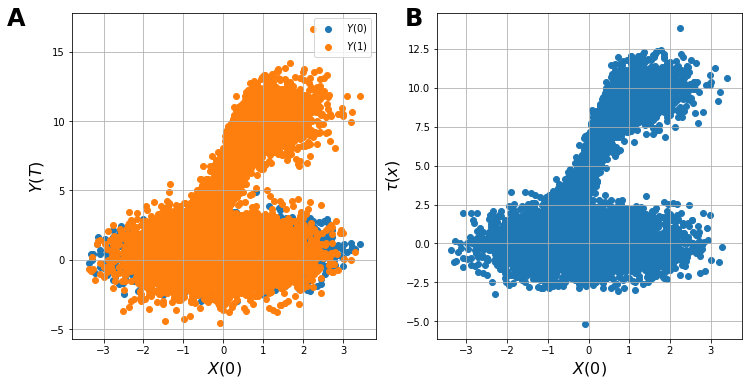

In [3]:
# Make figure with two subplots
fig, ax = plt.subplots(1,2, figsize=(12,6))

# First subplot: Scatter plots of counterfactual outcomes against first explanatory variable
ax[0].scatter(X[:,0], Y0, label = '$Y(0)$')
ax[0].scatter(X[:,0], Y1, label = '$Y(1)$')

# Make first subplot nicer
ax[0].set_xlabel('$X(0)$', fontsize = 16)
ax[0].set_ylabel('$Y(T)$', fontsize = 16)
ax[0].legend()
ax[0].grid(True)

# Second subplot: Scatter plot of treatment effect against first explanatory variable
ax[1].scatter(X[:,0], Tau, label = '\tau(x)')

# Make second subplot nicer
ax[1].set_xlabel('$X(0)$', fontsize = 16)
ax[1].set_ylabel('$\\tau(x)$', fontsize = 16)
ax[1].grid(True)

# Add panel names
fig.text(0.05, 0.85, 'A', fontsize = 24, fontweight = 'bold')
fig.text(0.51, 0.85, 'B', fontsize = 24, fontweight = 'bold')

# Save figure
plt.savefig('fig1.pdf')

# COMMENTS:
# Panel A:
# - The outcome when not treated is a linear function of X
# - The outcome when treated is for half of the individuals a linear function of X
# - The outcome when treated is for the other half the individuals a linear function of X plus a logistic function
# Panel B:
# - For half of the individuals, the treatment effect is noise centered on zero
# - For the other half of the individuals, the treatment effect is a logistic function

>**Ex 5.1.3.** Import `statsmodels` and estimate a simple linear regression
$$
y = \alpha + \delta_0 T + \sum_k \beta_k X_k + \epsilon
$$
>What is your estimate of $\hat{\delta}_0$? How does this number fit with the figures you drew in the previous exercise? Do you have any suggestions for improving the estimate of the model, comment on whether your improvements would provide unbiased estimates of $\tau$? 
>
> **Bonus:** fit your improved model, and relate the parameters you estimate to the figure you plotted in the previous question.

In [4]:
# Create dataframe of explanatory variables: Constant, treatment indicator and covariates
exog = pd.DataFrame({'Cons': np.ones(N_SAMPLES), 'Treat': T})
exog = pd.concat([exog, pd.DataFrame(X, columns = ['X0','X1','X2','X3','X4'])], axis = 1)

# Create series of the outcome variable
endog = pd.Series(y)

In [5]:
from statsmodels.api import OLS

# Fit model
mod = OLS(endog, exog).fit()
mod.summary()

# COMMENT: \delta = 2.5 is the estimate, which is roughly the mean of Tau
# For half of the individuals, the treatment is effect is zero, and for the other half it is much larger than 0.5
# The main issue is that that the treatment effect is heterogenous.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     883.0
Date:                Thu, 19 Mar 2020   Prob (F-statistic):               0.00
Time:                        14:23:27   Log-Likelihood:                -23328.
No. Observations:               10000   AIC:                         4.667e+04
Df Residuals:                    9993   BIC:                         4.672e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Cons           0.4429      0.035     12.518      0.000       0.374       0.512
Treat          2.4676      0.050     49.449      0.000       2.370       2.565
X0             0.9135      0.025     36.665      0.000       0.865       0.962
X1             0.8050      0.025     31.832      0.000       0.755       0.855
X2             0.3825      0.025     15.507      0.000       0.334       0.431
X3             0.1436      0.025      5.689      0.000       0.094       0.193
X4             0.3454      0.025     13.958      0.000       0.297       0.394
==============================================================================
Omnibus:                     1309.799   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2040.226
Skew:                           0.929   Prob(JB):                         0.00
Kurtosis:                       4.201   Cond. No.                         2.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

>**Ex. 5.1.4:** For this question we will need to move into R (or use rpy2). If you are working in python you can skip this step, otherwise do the following. 
>
> Save a dataframe, containing $X$, $y$, $T$, and $D$ as a csv file on your computer.

In [6]:
# Create dataframe of X, y, T, and D with correct names and save as CSV
df = pd.concat([endog, exog, pd.Series(D)], axis = 1)
df.columns = ['y','Cons','Treat','X0','X1','X2','X3','X4','D']
df.to_csv('data.csv')

>**Ex. 5.1.5:** Open up R and read the data you just saved into a dataframe(or work in rpy2). Install and load the two libraries `tidyverse` and `grf`.
>
> _Hint:_ to install the required packages. run this:
> ```R
> install.packages("tidyverse")
> install.packages("grf")
> ```

In [ ]:
# Done in R

>**Ex. 5.1.6:** Copy the following code into R to split your dataframe into two matrices, `X`, and `y`. Implement the exact same procedure to create a third matrix `W` which contains the treatment indicator (**Note** `T` is a reserved name in R, so name your third matrix `W`).
>```R
>X <- df %>%
  select(X0, X1, X2, X3, X4, D) %>% 
  as.matrix()
>
>y <- df %>%
  select(y) %>% 
  as.matrix()
>```
> Finally spend some time poking around the [GRF documentation](https://github.com/grf-labs/grf). See if you can figure out how to estimate a GRF model, once you have the three matrices you need (this is way simpler than you might expect).

In [ ]:
# Done in R

>**Ex. 5.1.7:** Estimate a causal forest model using the GRF package, and store the result in a new variable `cf`. Then use the following line to create a dataframe of predicted treatment effects on the same data that you trained the model on. 
>```R
>cf <- # Estimate a generalized RF model aimed at treatment effects.
>tau <- predict(cf, X)
>```
> Once you have your individual treatment effects, run the following line, to save them in a csv file. 
> ```R
> write.csv(tau, "individual_treatment_effects.csv")
> ```

In [ ]:
# Done in R

>**Ex. 5.1.8:** This concludes our venture into R. Now load the treatment effects into a pandas dataframe, and plot a scatterplot of the estimated individual treatment effects against the simulated "true" ITE's `Tau` that you produced in the beginning of this exercise set.

In [7]:
# Read predicted values
Tau_hat = pd.read_csv('individual_treatment_effects.csv').drop('Unnamed: 0', axis = 1)

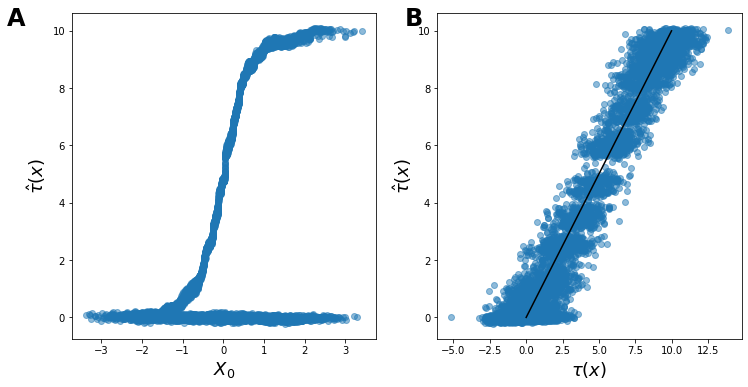

In [8]:
# Make figure
fig, ax = plt.subplots(1,2, figsize=(12,6))

# First subplot: Predicted tau against X0
ax[0].scatter(X[:,0], Tau_hat, alpha = 0.5)
ax[0].set_xlabel('$X_0$', fontsize = 18)
ax[0].set_ylabel('$\hat{\\tau}(x)$', fontsize = 18)

# Second subplot: Predicted tau against actual tau (with 45-degree line)
ax[1].scatter(Tau, Tau_hat, alpha = 0.5)
ax[1].plot([0,10],[0,10],color='black')
ax[1].set_xlabel('$\\tau(x)$', fontsize = 18)
ax[1].set_ylabel('$\hat{\\tau}(x)$', fontsize = 18)

# Add panel names
fig.text(0.05, 0.85, 'A', fontsize = 24, fontweight = 'bold')
fig.text(0.51, 0.85, 'B', fontsize = 24, fontweight = 'bold')

# Save figure
plt.savefig('fig2.pdf')

# COMMENT: 
# Panel A shows exactly the same thing as we saw with the real data: For half of the individuals,
# the treatment effect is 0. For the other half, it follows a logistic curve.
# Panel B shows that the esimates are right on average, since they are centered on the
# 45-degree line